In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16

`university-of-california-2016.csv` contains the 2016 salaries and names of all University of California employees, as reported by http://transparentcalifornia.com/salaries/university-of-california/

In [45]:
df = pd.read_csv('university-of-california-2016.csv')

/Users/samdixon/miniconda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We match first names to probable genders using a lookup table based on US Census records.

In [46]:
from gender import gender
gender_match = [gender[name.split()[0].upper()] if name.split()[0].upper() in gender.keys() else '' for name in df['Employee Name']]
gender_match = [gender[0] if isinstance(gender, tuple) else gender for gender in gender_match]
df['gender'] = gender_match

Let's look at the aggregate statistics throughout the whole UC system.

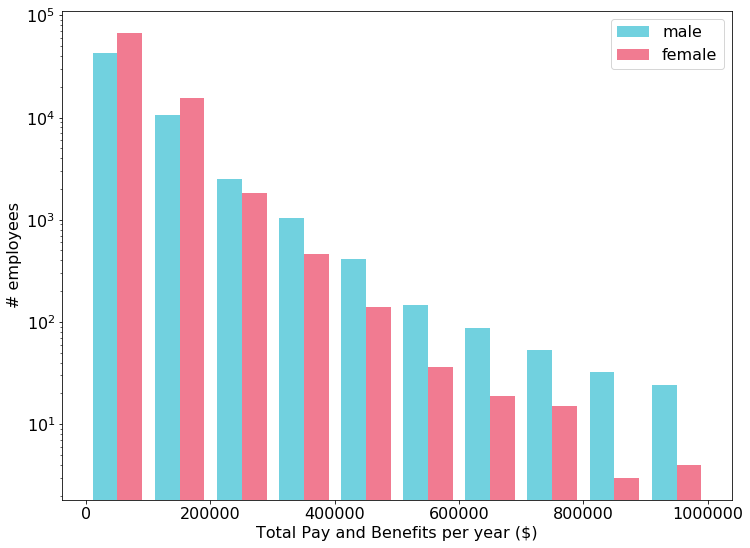

In [47]:
plt.hist([df[df['gender']=='male']['Total Pay & Benefits'],
          df[df['gender']=='female']['Total Pay & Benefits']], 
         bins=10, range=(1e3, 1e6), label=['male', 'female'],
         linewidth=3,
         color=['#71D1DF', '#F17B91'])
plt.yscale('log')
plt.legend()
plt.xlabel('Total Pay and Benefits per year ($)')
plt.ylabel('# employees')

Clearly, male employees are much more prevalent in higher paying positions. This dataset includes salary information for all UC employees. Notable outliers include football coaches and athletic directors (who are the highest paid employees of UC). In order to focus our analysis, we'll look only at professors.

In [48]:
profs = df[df['Job Title'].str.contains('PROF')]

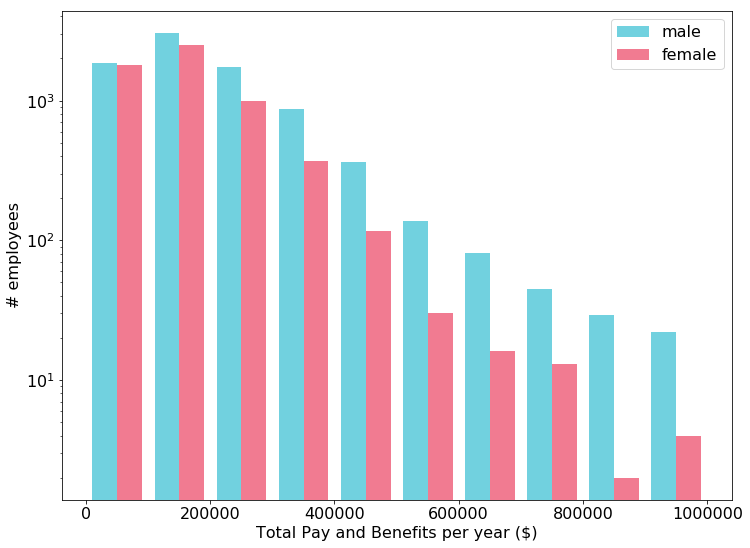

In [49]:
plt.hist([profs[profs['gender']=='male']['Total Pay & Benefits'],
          profs[profs['gender']=='female']['Total Pay & Benefits']], 
         bins=10, range=(1e3, 1e6), label=['male', 'female'],
         linewidth=3,
         color=['#71D1DF', '#F17B91'])
plt.yscale('log')
plt.legend()
plt.xlabel('Total Pay and Benefits per year ($)')
plt.ylabel('# employees')

Looking only at professors, we still see a similar story. Men are overrepresented in higher paying professorships. What's going on here? Let's break it down by job title.

In [50]:
def aggregate_salaries(data, control, gender_col_name='gender',
                       salary_col_name='Total Pay & Benefits', count_cut=10):
    """
    Gather the aggregate statistics in the data split by gender.
    Control variables that occur less than `count_cut` times are ignored.
    """
    all_cat_data = {}
    counts = data[control].value_counts()
    for cat in data[control].unique():
        if not isinstance(cat, str):
            continue
        if counts[cat] < count_cut:
            continue
        cat_data = {}
        cat_data['mean_female'] = data[(data[gender_col_name]=='female') & (data[control]==cat)].mean()[salary_col_name]
        cat_data['mean_male'] = data[(data[gender_col_name]=='male') & (data[control]==cat)].mean()[salary_col_name]
        cat_data['mean'] = data[(data[gender_col_name]!='') & (data[control]==cat)].mean()[salary_col_name]
        cat_data['median_female'] = data[(data[gender_col_name]=='female') & (data[control]==cat)].median()[salary_col_name]
        cat_data['median_male'] = data[(data[gender_col_name]=='male') & (data[control]==cat)].median()[salary_col_name]
        cat_data['median'] = data[(data[gender_col_name]!='') & (data[control]==cat)].median()[salary_col_name]
        all_cat_data[cat] = cat_data
    df = pd.DataFrame.from_dict(all_cat_data).T
    return df

In [51]:
def gender_gap_vis(data, control, gender_col_name='gender',
                   salary_col_name='Total Pay & Benefits', count_cut=10):
    """
    Make the gender gap visualization.
    """
    plt.figure(figsize=(18, 12))
    df = aggregate_salaries(data, control, gender_col_name, salary_col_name, count_cut)
    for i, kv in enumerate(df.sort_values('median').iterrows()):
        if i == 0:
            plt.plot([i, i], [kv[1]['median']/1000., kv[1]['median_male']/1000.], '#71D1DF', linewidth=3, label='male')
            plt.plot([i, i], [kv[1]['median']/1000., kv[1]['median_female']/1000.], '#F17B91', linewidth=3, label='female')
            plt.scatter(i, kv[1]['median']/1000., c='k', zorder=100, label='overall')
        else:
            plt.plot([i, i], [kv[1]['median']/1000., kv[1]['median_male']/1000.], '#71D1DF', linewidth=3)
            plt.plot([i, i], [kv[1]['median']/1000., kv[1]['median_female']/1000.], '#F17B91', linewidth=3)
            plt.scatter(i, kv[1]['median']/1000., c='k', zorder=100)
        plt.scatter(i, kv[1]['median_male']/1000., c='#71D1DF', zorder=100)
        plt.scatter(i, kv[1]['median_female']/1000., c='#F17B91', zorder=100)
    plt.gca().set_xticks(range(len(df.index.values)));
    plt.gca().set_xticklabels(df.sort_values('median').index.values);
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('Median {} (Thousands of $)'.format(salary_col_name))

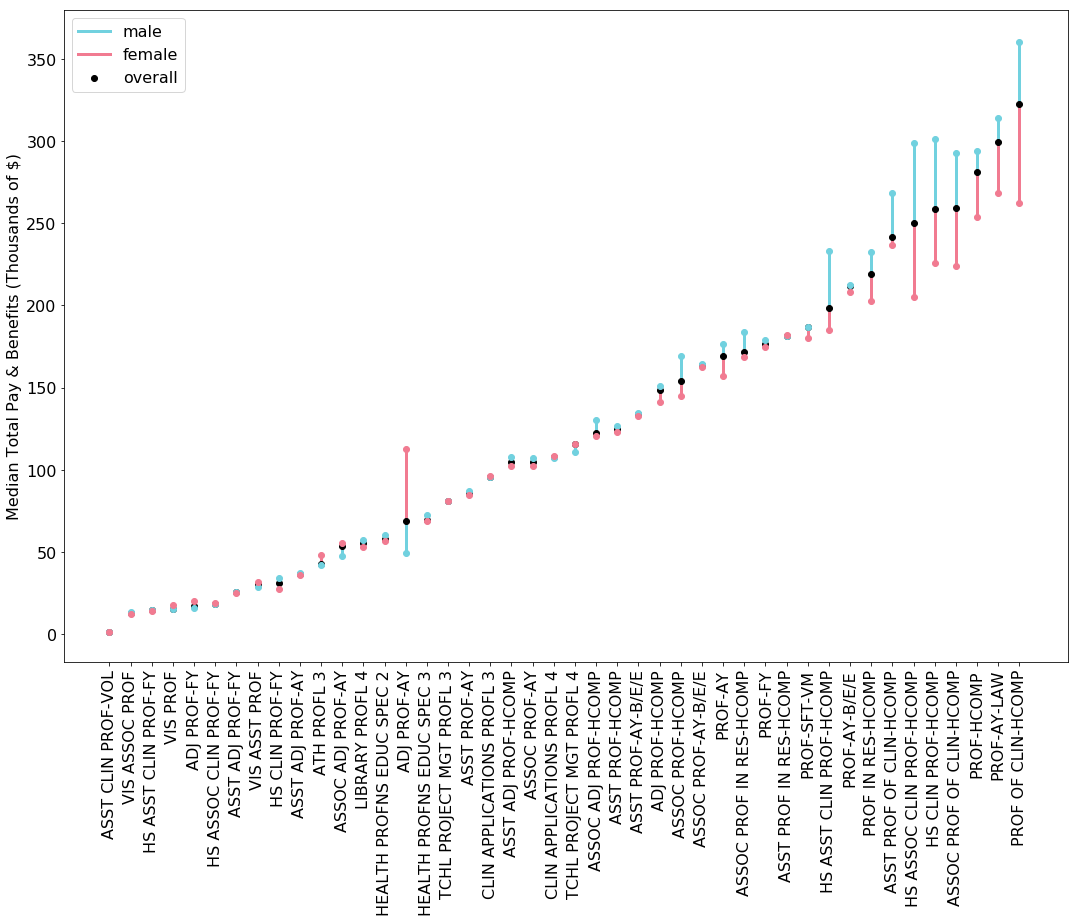

In [52]:
gender_gap_vis(profs, 'Job Title', count_cut=50)

The pay gap is particularly pronounced for higher-paying and higher prestige positions. One notable exception the sign of the gap is for adjunct (i.e. non-tenure track positions).

It would also be interesting to see how the department the professors teach in contribute to the size of the gap. Unfortunately, the department is not included in the Transparent California data set. However, we scraped Rate My Professors to find the names, campuses, and departments of many UC professors. Let's take a look at this data too.

In [53]:
dept_data = pd.read_csv('prof_data_from_rmp.csv', usecols=(1, 2, 3))
dept_data['ordered_name'] = [(' '.join(name.split(',')[::-1]).strip()) for name in dept_data['name']]
profs = dept_data.merge(profs, left_on='ordered_name', right_on='Employee Name')
profs = profs.drop_duplicates()

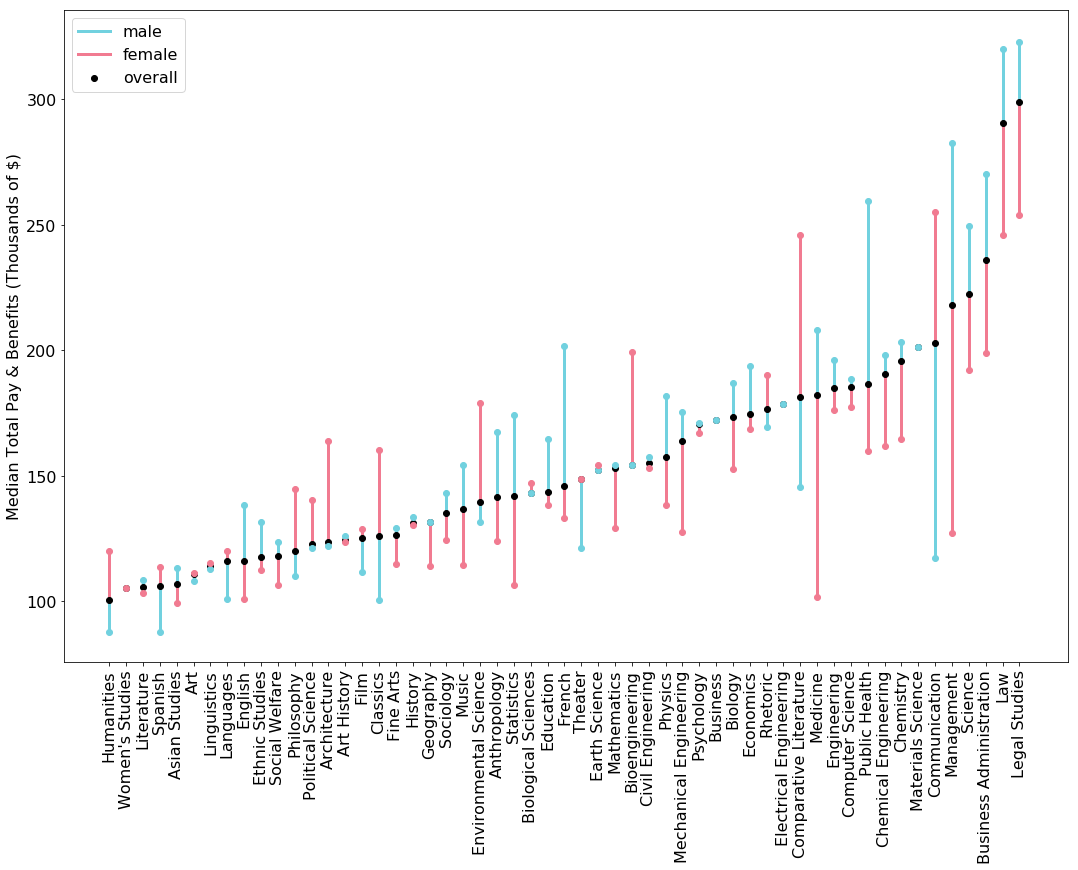

In [54]:
gender_gap_vis(profs, 'department')

Once again, women are under represented in the higher paying departments (business, law, many STEM fields). Female professors generally earn more than men in the arts and humanities. One interesting outlier is the "Science" department, where women outearn men.

How do the different campuses compare? Let's see...

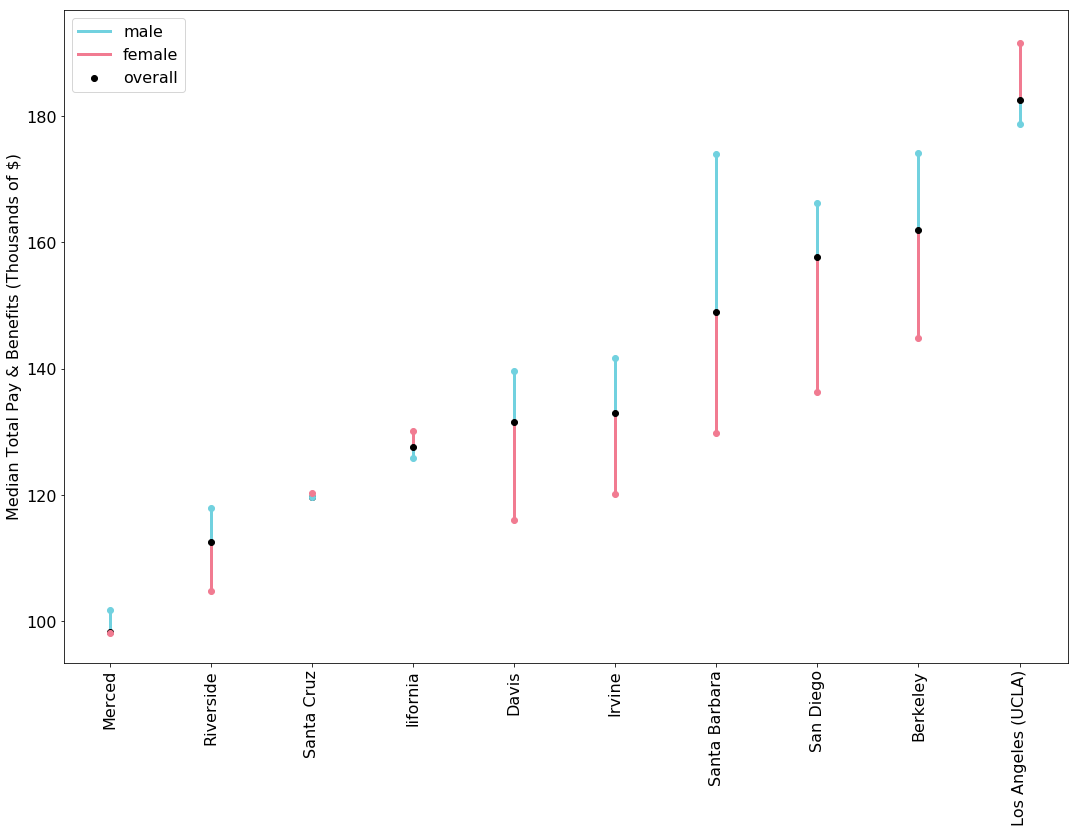

In [55]:
gender_gap_vis(profs, 'location')

UCLA and Santa Cruz are the only campuses where women, on average, earn more than men. The pay gaps are smallest at Merced and Santa Cruz, and particularly pronounces at UCSB, UCSD, and Berkeley.